In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import zscore, t

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import statsmodels as sm   # contains good statistical tools for modeling

from statsmodels.stats.outliers_influence import variance_inflation_factor  # we will need vif for checking multicollinearity
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import learning_curve

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score, mean_absolute_error

import os, pickle, csv
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import warnings
import pandas.util.testing as tm

warnings.filterwarnings('ignore')
plt.style.use('ggplot')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [81]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/servo/servo.data'
column_names = ['motor','screw','pgain','vgain','class']

df = pd.read_csv(uploaded,names=column_names)
df.dtypes

motor     object
screw     object
pgain      int64
vgain      int64
class    float64
dtype: object

In [82]:
columns = ['motor','screw','pgain','vgain']
#scale independent variables,
df[['motor','screw']] = OrdinalEncoder().fit_transform(df[['motor','screw']])

df[columns]=StandardScaler().fit_transform(df[columns])

#apply z-score outlier treatment
z = np.abs(zscore(df))
df = df[(z < 3).all(axis=1)]

In [83]:
X=df[column_names[:-1]]
y=df[column_names[-1]]
print(X.shape)
pd.DataFrame(data=[df.skew(),df.kurtosis()],index=['skewness','kurtosis'])
X.head(5)

(165, 4)


,motor,screw,pgain,vgain
0,1.504301,1.524517,0.832065,1.069805
1,-0.624667,0.826998,1.817560,1.802008
2,0.794645,0.826998,-0.153430,0.337602
3,-0.624667,-1.265558,-1.138926,-0.394600
4,0.794645,-0.568039,1.817560,1.802008


Removing features with low variance, checking scores

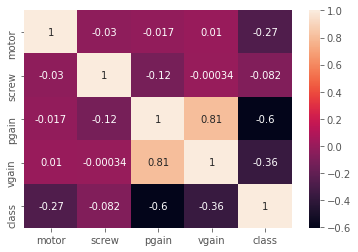

In [ ]:
sns.heatmap(df.corr(),annot=True)

In [ ]:
X1 = sm.tools.add_constant(df) 

series1 = pd.Series([variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])],
                  index=X1.columns)

series1

const    2.844480
motor    1.187364
screw    1.138525
pgain    5.197153
vgain    3.455773
class    2.140103
dtype: float64

Correlation between pgain and class can be noticed, but variance inflation factor of pgain is almost 5. We have concluded to leave all features.

In [ ]:
numerical_features = df.select_dtypes(exclude=['object']).drop(['class'], axis=1).copy()
print(numerical_features.columns)

Index(['motor', 'screw', 'pgain', 'vgain'], dtype='object')


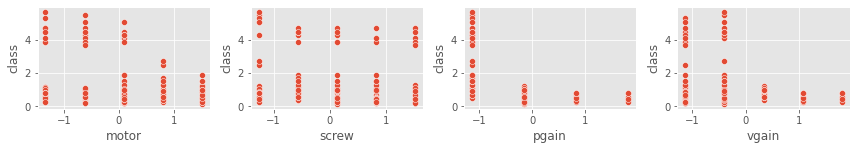

In [ ]:
fig = plt.figure(figsize=(12,18))
for i in range(4):
    fig.add_subplot(9, 4, i+1)
    sns.scatterplot(numerical_features.iloc[:, i],df['class'])
plt.tight_layout()
plt.show()

Outlier Detection and Removal


In [84]:
outliers = LocalOutlierFactor(n_neighbors=20).fit_predict(X)
target_out = LocalOutlierFactor(n_neighbors=20).fit_predict(y.values.reshape(-1, 1))
outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X,y=X[outliers],y[outliers]
X_2,y_2=X,y

print(X.shape)


(152, 4)


## Linear model tree

In [ ]:
import requests


url_linreg = 'https://raw.githubusercontent.com/ankonzoid/LearningX/master/advanced_ML/model_tree/models/linear_regr.py'
url_modeltree='https://raw.githubusercontent.com/ankonzoid/LearningX/master/advanced_ML/model_tree/src/ModelTree.py'

r = requests.get(url_linreg, allow_redirects=True)
with open('linear_regr.py', 'wb') as file:
  file.write(r.content)

r = requests.get(url_modeltree, allow_redirects=True)
with open('ModelTree.py', 'wb') as file:
  file.write(r.content)


# from google.colab import files
# uploaded = files.upload()

In [ ]:
from ModelTree import ModelTree
from linear_regr import linear_regr

In [ ]:
cv_sets = KFold(n_splits=10, shuffle= True,random_state=100)
param_grid = {
              "max_depth": [1,2,3,4,5,6,7],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10],
              # "search_type": ["greedy", "grid", "adaptive"],
              # "n_search_grid": [50,100,200]
              }

In [ ]:
model = linear_regr()
model_tree = ModelTree(model, max_depth=5, min_samples_leaf=5,
                        search_type="greedy", n_search_grid=100)

In [ ]:
error_metric='neg_mean_absolute_error'
# error_metric='neg_mean_squared_error'

grid = GridSearchCV(model_tree, param_grid,cv=cv_sets,n_jobs=4,scoring=error_metric)

In [ ]:
try:
  X=X.to_numpy()
except:
  print('already converted to numpy')
try:
  y=y.to_numpy()
except:
  print('already converted to numpy')
grid = grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_estimator_))

Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x7faf934167d0>, max_depth=5, min_samples_leaf=5, search_type=greedy, n_search_grid=100)


In [ ]:
lmt_t = grid.best_estimator_

In [ ]:
df = pd.DataFrame(data=grid.cv_results_)

[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

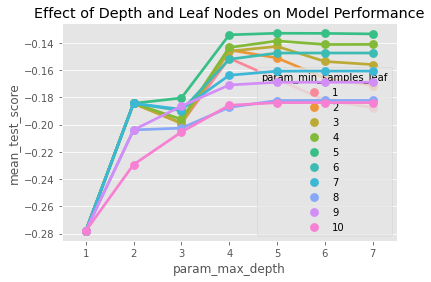

In [ ]:
fig,ax = plt.subplots()
sns.pointplot(data=df[['mean_test_score',
                           'param_min_samples_leaf',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_min_samples_leaf',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

In [ ]:
def get_soc(D,f):
    return (2*D+1)+(2*f)

In [ ]:
folds = cv_sets
print(X.shape)
# X=X.to_numpy()
mse = cross_val_score(lmt_t,X,y,cv=folds,scoring='neg_mean_squared_error')
mse=np.abs(np.mean(mse))
print("Mean Squared Error: {}".format(mse))
rmse=math.sqrt(mse)
print("Root Mean Squared Error: {}".format(rmse))
mae = cross_val_score(lmt_t,X,y,cv=folds,scoring='neg_mean_absolute_error')
mae = np.abs(np.mean(mae))
print("mean absolute error: {}".format(mae))
r2 = cross_val_score(lmt_t,X,y,cv=folds,scoring='r2')
r2 = np.abs(np.mean(r2))
print("Overall model accuracy: {}".format(r2))
soc=get_soc(lmt_t.max_depth,X.shape[1])
print("SOC: {}".format(soc))

(152, 4)
Mean Squared Error: 0.07847121949414483
Root Mean Squared Error: 0.28012714879879963
mean absolute error: 0.13290358699858204
Overall model accuracy: 0.9043590574244957
SOC: 19


In [ ]:
mses = []
SOCs = []
arr_maes = []
max_depth = []
leaves = []
print(X.shape)
# X=X.to_numpy()
# y=y.to_numpy()
for x in range(1,8):
  cv_sets = KFold(n_splits=10, shuffle= True,random_state=100)
  param_grid = {
                "max_depth": [x],
                "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10]
  }  
  grid = GridSearchCV(model_tree, param_grid,cv=cv_sets,n_jobs=4,scoring=error_metric)
  grid = grid.fit(X, y)
  print("Best Hyperparameters::\n{}".format(grid.best_estimator_))
  lmt = grid.best_estimator_
  mse = cross_val_score(lmt,X,y,cv=cv_sets,scoring='neg_mean_squared_error')
  mae = cross_val_score(lmt,X,y,cv=cv_sets,scoring='neg_mean_absolute_error')

  mse=np.abs(np.mean(mse))
  mses.append(mse)
  mae=np.abs(np.mean(mae))
  arr_maes.append(mae)
  soc=get_soc(x,X.shape[1])
  SOCs.append(soc)
  max_depth.append(x)
print(SOCs);
mses

(152, 4)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x7f0bff5b3ad0>, max_depth=1, min_samples_leaf=1, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x7f0bff56aa90>, max_depth=2, min_samples_leaf=1, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x7f0bff562a10>, max_depth=3, min_samples_leaf=5, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x7f0bff51ad90>, max_depth=4, min_samples_leaf=5, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x7f0bff56c910>, max_depth=5, min_samples_leaf=5, search_type=greedy, n_search_grid=100)
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x7f0bff51a350>, max_depth=6, min_samples_leaf=5, search_type=greedy, n_search_grid=100)
Best Hyperpar

[0.17482696110819593,
 0.09224561912583662,
 0.09635292897499668,
 0.07613541771674934,
 0.07847121949414483,
 0.07849879789191516,
 0.07851612989747077]

In [ ]:
min_samples_leaf=[1,1,5,5,5,5,5]
arr_maes

[0.2781010673847818,
 0.1843904222013542,
 0.18047363327529956,
 0.13406996047394942,
 0.13290358699858204,
 0.13300609685743436,
 0.13340303916603086]

In [ ]:
for x in range(1,8,2):
  LMT = ModelTree(model, max_depth=4, min_samples_leaf=x,
                          search_type="greedy", n_search_grid=100)
  mse = cross_val_score(LMT,X,y,cv=cv_sets,scoring='neg_mean_squared_error')
  mae = cross_val_score(LMT,X,y,cv=cv_sets,scoring='neg_mean_absolute_error')

  mse=np.abs(np.mean(mse))
  mses.append(mse)
  mae=np.abs(np.mean(mae))
  arr_maes.append(mae)
  soc=get_soc(x,X.shape[1])
  SOCs.append(soc)
  max_depth.append(4)
  min_samples_leaf.append(x)

In [ ]:
arr_mse_min = [0.078]
arr_mae_min = min(arr_maes)
arr_soc_min = [19]
print("Lowest Mean Squared Error: {}".format(arr_mse_min))
print("Lowest Mean Absolute Error: {}".format(arr_mae_min))
print(SOCs)
print(mses)
print(arr_maes)
arr_mse_min_soc = [0.076135]					
arr_mae_min_soc = [0.134070]
arr_soc_min_soc = [17]

Lowest Mean Squared Error: [0.078]
Lowest Mean Absolute Error: 0.13290358699858204
[11, 13, 15, 17, 19, 21, 23, 11, 15, 19, 23]
[0.17482696110819593, 0.09224561912583662, 0.09635292897499668, 0.07613541771674934, 0.07847121949414483, 0.07849879789191516, 0.07851612989747077, 0.129190626449502, 0.11647373818394693, 0.07613541771674934, 0.10632915679050141]
[0.2781010673847818, 0.1843904222013542, 0.18047363327529956, 0.13406996047394942, 0.13290358699858204, 0.13300609685743436, 0.13340303916603086, 0.15124885272559688, 0.14610188249768108, 0.13406996047394942, 0.1637424287066448]


In [ ]:
arr_mse_not_allowed = [ x for x in mses if x >= arr_mse_min*1.1 ]
arr_mae_not_allowed = [ x for x in arr_maes if x >= arr_mae_min*1.1 ]
arr_mse_not_allowed, arr_mae_not_allowed

([0.17482696110819593,
  0.09224561912583662,
  0.09635292897499668,
  0.129190626449502,
  0.11647373818394693,
  0.10632915679050141],
 [0.2781010673847818,
  0.1843904222013542,
  0.18047363327529956,
  0.15124885272559688,
  0.1637424287066448])

In [ ]:
arr_mse_not_allowed_soc = [11, 13,15,11,15,23]
arr_mae_not_allowed_soc = [11, 13, 15,11,23]

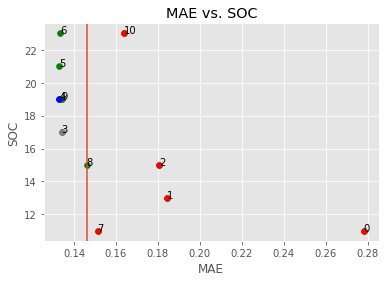

In [ ]:
plt.title("MAE vs. SOC")

plt.scatter(arr_maes, SOCs, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min_soc, arr_soc_min_soc, c='grey')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.axvline(x=arr_mae_min*1.1)
for i, txt in enumerate(mses):
    plt.annotate(i, (arr_maes[i], SOCs[i]))
plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

In [49]:
data = { 'MSE': mses, 'MAE': arr_maes, 'SOC': SOCs, 'max_depth ': max_depth,  'min_samples_leaf ': min_samples_leaf }
df2 = pd.DataFrame(data)
df2

,MSE,MAE,SOC,max_depth,min_samples_leaf
0,0.174827,0.278101,11,1,1
1,0.092246,0.184390,13,2,1
2,0.096353,0.180474,15,3,5
3,0.076135,0.134070,17,4,5
4,0.078471,0.132904,19,5,5
5,0.078499,0.133006,21,6,5
6,0.078516,0.133403,23,7,5
7,0.129191,0.151249,11,4,1
8,0.116474,0.146102,15,4,3
9,0.076135,0.134070,19,4,5


In [57]:
df_header = df.columns.values  # header
header = list(df_header)
header

['motor', 'screw', 'pgain', 'vgain', 'class']

In [65]:
k=4
bestfeatures = SelectKBest(score_func=f_regression, k=k)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(header)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(k,'Score')) 

   Specs      Score
2  pgain  84.498301
3  vgain  22.668209
0  motor  11.999011
1  screw   0.074505


In [85]:
X_new=X.drop(['screw'], axis=1)
X_new.shape

(152, 3)

In [101]:
cv_sets = KFold(n_splits=10, shuffle= True,random_state=100)
param_grid_2 = {
              "max_depth": [1,2,3,4,5,6,7,8,9,10],
              "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10],
              # "search_type": ["greedy", "grid", "adaptive"],
              # "n_search_grid": [50,100,200]
              }

In [102]:
grid = GridSearchCV(model_tree, param_grid_2,cv=cv_sets,n_jobs=4,scoring=error_metric)

In [103]:
try:
  X_new=X_new.to_numpy()
except:
  print('already converted to numpy')
try:
  y=y.to_numpy()
except:
  print('already converted to numpy')
grid = grid.fit(X_new, y)

print("Best Hyperparameters::\n{}".format(grid.best_estimator_))

already converted to numpy
already converted to numpy
Best Hyperparameters::
ModelTree(model=<linear_regr.linear_regr object at 0x7f0bf20ae750>, max_depth=4, min_samples_leaf=7, search_type=greedy, n_search_grid=100)


In [104]:
lmt_t_2 = grid.best_estimator_
df2 = pd.DataFrame(data=grid.cv_results_)
df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.679826,0.114494,0.002711,0.002133,1,1,"{'max_depth': 1, 'min_samples_leaf': 1}",-0.354498,-0.311216,-0.222911,-3.606488e-01,-0.513037,-0.337783,-0.442780,-0.227375,-0.307012,-0.245210,-3.322472e-01,8.822799e-02,57
1,1.651147,0.030155,0.003472,0.002936,1,2,"{'max_depth': 1, 'min_samples_leaf': 2}",-0.354498,-0.311216,-0.222911,-3.606488e-01,-0.513037,-0.337783,-0.442780,-0.227375,-0.307012,-0.245210,-3.322472e-01,8.822799e-02,57
2,1.649164,0.018479,0.003006,0.002539,1,3,"{'max_depth': 1, 'min_samples_leaf': 3}",-0.354498,-0.311216,-0.222911,-3.606488e-01,-0.513037,-0.337783,-0.442780,-0.227375,-0.307012,-0.245210,-3.322472e-01,8.822799e-02,57
3,1.649313,0.020636,0.007202,0.003532,1,4,"{'max_depth': 1, 'min_samples_leaf': 4}",-0.354498,-0.311216,-0.222911,-3.606488e-01,-0.513037,-0.337783,-0.442780,-0.227375,-0.307012,-0.245210,-3.322472e-01,8.822799e-02,57
4,1.656657,0.030645,0.004127,0.003288,1,5,"{'max_depth': 1, 'min_samples_leaf': 5}",-0.354498,-0.311216,-0.222911,-3.606488e-01,-0.513037,-0.337783,-0.442780,-0.227375,-0.307012,-0.245210,-3.322472e-01,8.822799e-02,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.247486,0.111292,0.004235,0.003336,10,6,"{'max_depth': 10, 'min_samples_leaf': 6}",-0.215714,-0.200540,-0.222218,-3.253505e+12,-0.294095,-0.332223,-0.180619,-0.203376,-0.176424,-0.210370,-3.253505e+11,9.760514e+11,74
96,5.073726,0.101815,0.005012,0.003472,10,7,"{'max_depth': 10, 'min_samples_leaf': 7}",-0.234071,-0.178985,-0.222531,-3.253505e+12,-0.294070,-0.325579,-0.180619,-0.203349,-0.176020,-0.197874,-3.253505e+11,9.760514e+11,68
97,4.943877,0.124865,0.003638,0.002829,10,8,"{'max_depth': 10, 'min_samples_leaf': 8}",-0.235514,-0.190333,-0.199883,-3.253505e+12,-0.294070,-0.325579,-0.379087,-0.171302,-0.141813,-0.170297,-3.253505e+11,9.760514e+11,92
98,4.851425,0.147729,0.005099,0.003484,10,9,"{'max_depth': 10, 'min_samples_leaf': 9}",-0.232542,-0.190333,-0.199883,-3.253505e+12,-0.294070,-0.327021,-0.366713,-0.171302,-0.141813,-0.168125,-3.253505e+11,9.760514e+11,86


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

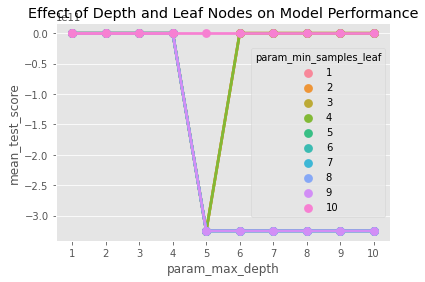

In [105]:
df2 = pd.DataFrame(data=grid.cv_results_)
fig,ax = plt.subplots()
sns.pointplot(data=df2[['mean_test_score',
                           'param_min_samples_leaf',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_min_samples_leaf',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

In [107]:
folds = cv_sets

print(X_new.shape)
# X=X.to_numpy()
mse = cross_val_score(lmt_t_2,X_new,y,cv=folds,scoring='neg_mean_squared_error')
mse=np.abs(np.mean(mse))
print("Mean Squared Error: {}".format(mse))
rmse=math.sqrt(mse)
print("Root Mean Squared Error: {}".format(rmse))
mae = cross_val_score(lmt_t_2,X_new,y,cv=folds,scoring='neg_mean_absolute_error')
mae = np.abs(np.mean(mae))
print("mean absolute error: {}".format(mae))
r2 = cross_val_score(lmt_t_2,X_new,y,cv=folds,scoring='r2')
r2 = np.abs(np.mean(r2))
print("Overall model accuracy: {}".format(r2))
soc=get_soc(lmt_t_2.max_depth,X_new.shape[1])
print("SOC: {}".format(soc))

(152, 3)
Mean Squared Error: 0.13563988462031823
Root Mean Squared Error: 0.3682932046893049
mean absolute error: 0.22071011819413466
Overall model accuracy: 0.8580559201878799
SOC: 15


In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])
_,train_scores,validation_scores=learning_curve(lmt_t,X,y,cv=folds,train_sizes=train_sizes,scoring=error_metric)

In [ ]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 0.1    0.044286
0.2    0.109741
0.3    0.130009
0.4    0.088436
0.5    0.073197
1.0    0.062452
dtype: float64

 --------------------

Mean validation scores

 0.1    1.487344e+00
0.2    4.306923e-01
0.3    3.782675e-01
0.4    7.507750e+10
0.5    2.541801e-01
1.0    1.325909e-01
dtype: float64


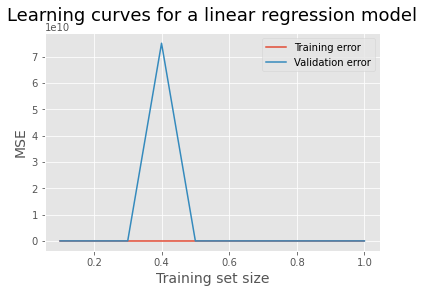

In [ ]:
plt.title("Learning curve")

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.legend()
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()